Considerando una bomba modelo B3Z-M en el tramo 1, con un diámetro de 8,438’’ (Página 45 del catálogo Berkeley)
Determinar el caudal de operación.

![Ejemplo 2](images/M2_E2.png)

Datos:
* Cañerías de acero comercial
* L1 = 7 m
* L2 = 15 m
* L3 = 20 m
* L4 = 5 m
* D1 = 5 cm
* D2 = D3 = D4 = 6 cm
* 2 codos de 45º
* 1 codo de 90° en cada tramo (2 y 3)
* 2 uniones T.


In [1]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
from scipy import constants
from scipy import optimize as op
from fluids.vectorized import * 

Datos:

In [2]:
g = constants.value(u'standard acceleration of gravity')

D = np.array([5 , 6, 6, 6]) /100 #Centímetros a metros
L = np.array([7, 15, 20, 5])
z = 20

epsilon = 0.0046/10

fluid = "water"
rho = cp.PropsSI('D','T', 300, 'P',101325,fluid)
mu = cp.PropsSI('V','T', 300, 'P',101325,fluid)


$\Delta P_2 = \Delta P_3\\$
$\dot{V}_1 = \dot{V}_2 + \dot{V}_3$

La ecuación de Bernouilli se puede hacer por cada uno de los tramos: 1, 2, 3 y 4. Luego pueden sumarse entre sí. 

Balance de energía tramo 1-2-4:

 $\rho g z_{AB} + H_p =\left( {\frac{1}{2}\rho v_{1}^{2}\left( {\frac{f_1 L_1}{D_1}+K_1} \right)} \right)+\frac{1}{2}\rho v_{2}^{2}\left( {\frac{f_2 L_2}{D_2}+K_2} \right) + \left( {\frac{1}{2}\rho v_{4}^{2}\left( {\frac{f_4 L_4}{D_4}+K_4} \right)} \right)$


Para aplicar el Método Hardy-Cross Expresamos las ecuaciones en función de los caudales

$\rho g z_{AB} + H_p = \Delta P_1 + \Delta P_2 + \Delta P_4$

$\rho g z_{AB} + H_p = \Delta P_1 + \Delta P_3 + \Delta P_4$


donde,

$ \Delta P_1 = \frac{1}{2}\rho v_{1}^{2}\left( {\frac{f_1 L_1}{D_1}+K_1} \right) = \frac{8 \rho \forall_{1}^{2} }{\pi D_1^4}\left( {\frac{f_1 L_1}{D_1}+K_1} \right)  $

$ \Delta P_2 = \frac{8 \rho \forall_{2}^{2} }{\pi D_2^4}\left( {\frac{f_2 L_2}{D_2}+K_2} \right)  $

$ \Delta P_3 = \frac{8 \rho \forall_{3}^{2} }{\pi D_3^4}\left( {\frac{f_3 L_2}{D_3}+K_3} \right)  $

$ \Delta P_4 = \frac{8 \rho \forall_{4}^{2} }{\pi D_4^4}\left( {\frac{f_4 L_2}{D_4}+K_4} \right)  $


$C_{i}=\frac{8}{\pi  g D_{i}^{4}}\left( {\frac{f_i L_i}{D_i}+K_i} \right)$

Determinamos los valores de K (Crane) que no dependen del caudal

In [3]:
#Tramo 1
K_1 = fld.entrance_sharp() + fld.diffuser_sharp(Di1=D[0], Di2=D[1])
#Tramo 2
#K_2_c =  2 * fld.bend_rounded_Crane(Di=D[1], bend_diameters=1, angle=45) + fld.bend_rounded_Crane(Di=D[1], bend_diameters=1, angle=90)
K_2_c =  2 * 0.35 + 1.4
#Tramo 3
#K_3_c= fld.bend_rounded_Crane(Di=D[2], bend_diameters=1, angle=90)
K_3_c = 1.4
#Tramo 4
K_4 = fld.exit_normal()

K = np.array([K_1, K_2_c, K_3_c, K_4])
K

array([0.6633642, 2.1      , 1.4      , 1.       ])

Cabezal de la bomba


In [4]:
Hp = np.array(range(30))

In [5]:
def variations(V_dot,EHp):
    DELTA[0] = - ((C[0] + C[3]) * V_dot[0] * abs(V_dot[0]) + C[1] * V_dot[1] * abs(V_dot[1]) - z - EHp) / (2 * C[1]* abs(V_dot[1]) + 2*(C[0] + C[3])* abs(V_dot[0]))
    DELTA[2] = - (C[2] * V_dot[2] * abs(V_dot[2]) - C[1] * V_dot[1] * abs(V_dot[1])) / (2 * C[2]* abs(V_dot[2]) + 2*C[1]* abs(V_dot[1]))
    DELTA[1] =  DELTA[0] - DELTA[2]
    DELTA[3] =  DELTA[0]
    return DELTA

In [6]:
V_dot_plot = np.empty(0)

for j in Hp:
    V_dot = np.array([20 , 10, 10, 20])/1000
    DELTA = np.ones(4)/1000
    for i in range(100):
        V = (V_dot * 4)/(np.pi * D*D)
        Re = Reynolds(D, rho, V, mu)
        f = friction_factor(Re, eD=epsilon/D)
        K_2_T = fld.K_run_diverging_Crane(D[2], D[2], V_dot[1], V_dot[2], angle=90) + fld.K_branch_converging_Crane(D[2], D[1],V_dot[2],V_dot[1], angle=90)
        K[1] = K_2_c + K_2_T 
        K_3_T =  fld.K_branch_diverging_Crane(D[2], D[2], V_dot[1], V_dot[2], angle=90) + fld.K_run_converging_Crane(D[2], D[1],V_dot[2],V_dot[1], angle=90)
        K[2] = K_3_c + K_3_T 
        C = (8/(np.pi**2 * g * D**4))  * (f * L/D + K)
        DELTA = variations(V_dot,Hp[j])
        V_dot += DELTA
        if DELTA[0]<=1e-6: 
            print(V_dot)
            break
    
    V_dot_plot = np.append(V_dot_plot, V_dot[0])

[0.01492326 0.00559317 0.00933009 0.01492326]
[0.01510437 0.00577428 0.00933009 0.01510437]
[0.01528548 0.00595539 0.00933009 0.01528548]
[0.01546659 0.0061365  0.00933009 0.01546659]
[0.0156477  0.00631761 0.00933009 0.0156477 ]
[0.01582881 0.00649872 0.00933009 0.01582881]
[0.01600992 0.00667983 0.00933009 0.01600992]
[0.01619103 0.00686094 0.00933009 0.01619103]
[0.01637214 0.00704205 0.00933009 0.01637214]
[0.01655325 0.00722316 0.00933009 0.01655325]
[0.01673436 0.00740427 0.00933009 0.01673436]
[0.01691547 0.00758538 0.00933009 0.01691547]
[0.01709658 0.00776649 0.00933009 0.01709658]
[0.01727769 0.0079476  0.00933009 0.01727769]
[0.0174588  0.00812871 0.00933009 0.0174588 ]
[0.01763991 0.00830982 0.00933009 0.01763991]
[0.01782102 0.00849093 0.00933009 0.01782102]
[0.01800213 0.00867204 0.00933009 0.01800213]
[0.01818324 0.00885315 0.00933009 0.01818324]
[0.01836435 0.00903426 0.00933009 0.01836435]
[0.01854546 0.00921537 0.00933009 0.01854546]
[0.01872657 0.00939648 0.00933009 

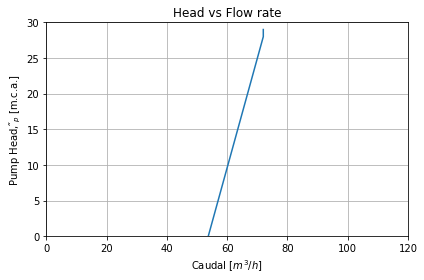

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(V_dot_plot*3600, Hp)
plt.xlabel("Caudal [$m^3/h$]")
plt.ylabel(r"Pump Head, $\H_p$ [m.c.a.]")
plt.title("Head vs Flow rate")
plt.xlim([0, 120])
plt.ylim([0, 30])
plt.grid(True)
plt.tight_layout()